In [20]:
import pandas as pd
import torch
import torchvision as tv
import torch.nn as nn

In [21]:
import model

In [22]:
%load_ext autoreload
%autoreload 2

%pylab inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [23]:
%run model.py

In [24]:
# model definition. training plan definition.

g = model.G()
g_loss = nn.BCELoss()
g_opt = torch.optim.Adam(g.parameters(), lr=2e-4)

d = model.D()
d_loss = nn.BCELoss()
d_opt = torch.optim.Adam(d.parameters(), lr=2e-4)

data_set = tv.datasets.MNIST('~/.ntdata',
    train=True,
    download=True,
    transform=tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5,), (0.5,))
    ]))
data_loader = torch.utils.data.DataLoader(data_set, batch_size=32, shuffle=True)

device = torch.device("cuda")

gan_manager = model.GANager(
        g,d,
        g_loss, d_loss,
        g_opt, d_opt,
        data_loader,
        device
        )

epoch_D_loss: 2318.185088276863
epoch_G_loss: 1753.2127509117126
epoch_D_on_real_sum: 34334.780608177185
epoch_D_on_fake_sum: 25680.093834877014
epoch_D_on_real_mean: 0.5722463434696198
epoch_D_on_fake_mean: 0.4280015639146169
time: 21.372589111328125
epoch_index: 99


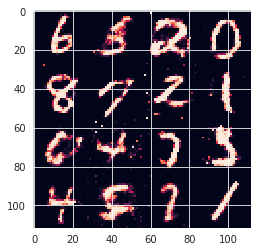

In [26]:
results = gan_manager.train(100)

In [27]:
# create a gif.

from matplotlib import animation, rc
from IPython.display import HTML, Image

images = [r['samples'] for r in results]

fig = plt.figure()
ims = [[plt.imshow(image, animated=True)] for image in images]
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
plt.close()
ani.save('samples.mp4')
HTML(ani.to_html5_video())

Text(0.5, 0, 'Epoch')

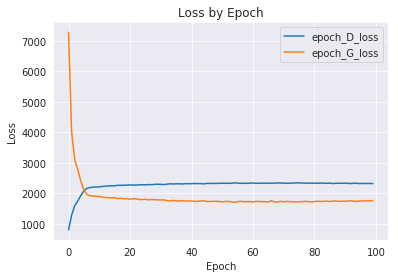

In [28]:
# plot epoch loss

import seaborn as sns
sns.set_style('darkgrid')

df = pd.DataFrame(results)
df[['epoch_D_loss', 'epoch_G_loss']].plot()
plt.title("Loss by Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")

Text(0.5, 0, 'Epoch')

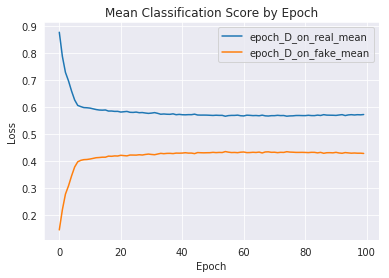

In [29]:
# plot mean classification by D

df = pd.DataFrame(results)
df[['epoch_D_on_real_mean', 'epoch_D_on_fake_mean']].plot()
plt.title("Mean Classification Score by Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")

In [30]:
# save the model state dicts

torch.save(gan_manager.G.state_dict(), 'G_weights.pt')
torch.save(gan_manager.D.state_dict(), 'D_weights.pt')

In [31]:
# show interpolation between two random samples in the latent space

with torch.no_grad():
    z1 = Variable(torch.rand(16, gan_manager.G.in_dim)).to(gan_manager.device)
    z2 = Variable(torch.rand(16, gan_manager.G.in_dim)).to(gan_manager.device)
    
    d_z = (z2 - z1)/50
    line = []
    for i in range(51):
        z = z1 + i*d_z
        samp = gan_manager.G(z)
        image = samp.detach().cpu().view(16, 28, 28)
        block_image = np.block([
            [image[0],  image[1],  image[2],  image[3]],
            [image[4],  image[5],  image[6],  image[7]],
            [image[8],  image[9],  image[10], image[11]],
            [image[12], image[13], image[14], image[15]],
        ])
        line.append(block_image)


fig = plt.figure()
ims = [[plt.imshow(image, animated=True)] for image in line]
ims += [[plt.imshow(image, animated=True)] for image in line[::-1]]
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=0)
plt.close()
ani.save('interpolation.mp4')
HTML(ani.to_html5_video())